<font size="7">THE INFERENCE NOTEBOOK FOR SINGLE HOUSE PREDICTION</font>

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import joblib
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [ ]:
class HousePricePredictor:
    def __init__(self, artifacts_dir="artifacts"):
        
        self.model = joblib.load(f"{artifacts_dir}/house_price_model.pkl")
        self.feature_names = joblib.load(f"{artifacts_dir}/feature_names.pkl")
        self.zip_wealth_map = joblib.load(f"{artifacts_dir}/zip_wealth_map.pkl")
        

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.resnet.to(self.device)
        self.resnet.eval()
        
        self.transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _fetch_mapbox_image(self, lat, lon, api_key):
        try:
            url = f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/{lon},{lat},18,0/600x600?access_token={api_key}"
            response = requests.get(url)
            if response.status_code == 200:
                return Image.open(BytesIO(response.content)).convert("RGB")
            else:
                print(f"Error fetching image: {response.status_code}")
                return None
        except Exception as e:
            print(f"Exception: {e}")
            return None

    def _get_image_embedding(self, img_obj):
        if img_obj is None: return np.zeros(512)
        try:
            img_t = self.transforms(img_obj).unsqueeze(0).to(self.device)
            with torch.no_grad():
                embedding = self.resnet(img_t)
            return embedding.cpu().numpy().flatten()
        except:
            return np.zeros(512)

    def _preprocess_tabular(self, raw_data):
        df = pd.DataFrame([raw_data])
        df['date'] = pd.to_datetime(df['date'])
        df['sale_month'] = df['date'].dt.month
        df['sale_year'] = df['date'].dt.year
        df['house_age'] = df['sale_year'] - df['yr_built']
        df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
        
        df['zip_wealth_rank'] = df['zipcode'].map(self.zip_wealth_map).fillna(540000)

        for i in range(1, 13):
            if f"month_{i}" in self.feature_names:
                df[f"month_{i}"] = (df['sale_month'] == i).astype(int)
        return df

    def predict(self, house_features, mapbox_api_key):
        lat, lon = house_features.get('lat'), house_features.get('long')
        print(f"Fetching satellite view for {lat}, {lon}...")
        img_obj = self._fetch_mapbox_image(lat, lon, mapbox_api_key)
        
        img_features = self._get_image_embedding(img_obj)
        
        df_processed = self._preprocess_tabular(house_features)
        
        img_df = pd.DataFrame([img_features], columns=[f"img_{i}" for i in range(512)])
        full_df = pd.concat([df_processed, img_df], axis=1)
        
        final_df = pd.DataFrame(columns=self.feature_names)
        for col in self.feature_names:
            final_df.loc[0, col] = full_df.iloc[0][col] if col in full_df.columns else 0
                
        return self.model.predict(final_df)[0], img_obj

In [13]:
predictor = HousePricePredictor()

new_house = {
    'date': '2025-01-08',
    'bedrooms': 4,
    'bathrooms': 3.5,
    'sqft_living': 3500,
    'sqft_lot': 10000,
    'floors': 2,
    'waterfront': 0,
    'view': 0,
    'condition': 3,
    'grade': 9,
    'sqft_above': 3500,
    'sqft_basement': 0,
    'yr_built': 2015,
    'yr_renovated': 0,
    'zipcode': 98039,
    'lat': 47.62,
    'long': -122.23,
    'sqft_living15': 3400,
    'sqft_lot15': 10000
}

c:\Users\piyus\miniconda3\envs\Img\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\piyus\miniconda3\envs\Img\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fetching satellite view for 47.62, -122.23...

Predicted Price: $1,843,381.00


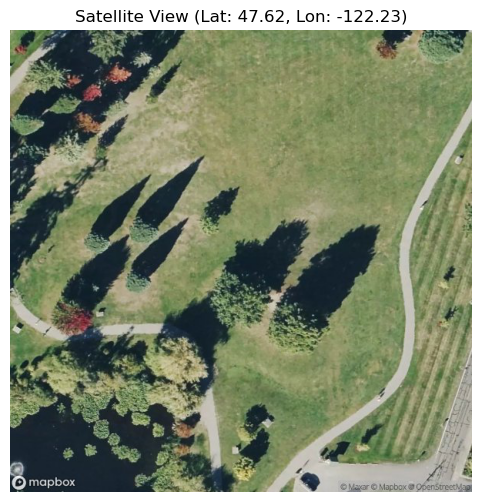

In [15]:
MAPBOX_KEY = "pk.eyJ1IjoicGl5dXNoLTA2MDYwNiIsImEiOiJjbWp3d3drYjYzaDRtM2RzZXdwb2p2cnpmIn0.oQ3z0H9hZuZqTl1TtCSfxA"

price, house_image = predictor.predict(new_house, MAPBOX_KEY)

print(f"\nPredicted Price: ${price:,.2f}")

plt.figure(figsize=(6, 6))
plt.imshow(house_image)
plt.axis('off')
plt.title(f"Satellite View (Lat: {new_house['lat']}, Lon: {new_house['long']})")
plt.show()